# Transmit Waveform Spectral Response

Spectral components of the classic Linear FM (chirp) sinusoidal waveform are compared to a return-to-zero pulse-width modulated chirp. The resulting waveforms are both low-pass filtered and the autocorrelation is computed.  The autocorrelation response amplitude and sensitivity (ambiguity function) provide a means to determine whether the PWM chirp is a reasonable alternative to the LFM chirp in the GAIA signal processing chain.   PWM chirps provide significant advantage in terms of power dissipation and circuit complexity for high-voltage (>50Vp-p) power amplifier design.

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt
import scipy
import scipy.fftpack
from scipy import signal
# formatting stuff
np.set_printoptions(linewidth=128)

class Caption():
    def __init__(self,s):
        self.s = s
    def _repr_html_(self):
        return '<center>{0}</center>'.format(self.s)
    def _repr_latex_(self):
        return '\\begin{center}\n'+self.s+'\n\\end{center}'

# python doesn't natively provide a switch-case construct. I prefer switch-case 
# over if-else and this class provides that functionality. You should only dig 
# into this if you need to understand how it works. 
class switch(object):
    def __init__(self, value):
        self.value = value
        self.fall = False

    def __iter__(self):
        """Return the match method once, then stop"""
        yield self.match
        raise StopIteration
    
    def match(self, *args):
        """Indicate whether or not to enter a case suite"""
        if self.fall or not args:
            return True
        elif self.value in args:
            self.fall = True
            return True
        else:
            return False
            
# window functions
def boxcar(n):
    return signal.boxcar(n)

def tukey(n):
    return signal.tukey(n,0.3)

def hann(n):
    return signal.hann(n)

def blackman(n):
    return signal.blackman(n)
    
def hamming(n):
    return signal.hamming(n)
    
def makeChirp(T, Fs, Fc, BW, wintype="none"):
    """ create complex linear chirp reference waveform.
        T = width of pulse (secs)
        Fs = sample rate (Hz)
        Fc = center frequency of pulse (Hz)
        BW = pulse bandwidth (Hz)
        wintype = window function applied, one of 
                [hann, blackman, hamming, boxcar]
                    default is boxcar (none)
    """
    t = np.arange(0, T, 1/Fs)
    real_chirp = np.transpose(signal.chirp(t,Fc-BW/2,T,Fc+BW/2, method='linear'))
    
    n = real_chirp.size

    for case in switch(wintype):
        if case('hann'):
            win = hann(n)
            break
        if case('blackman'):
            win = blackman(n)
            break
        if case('hamming'):
            win = hamming(n)
            break
        if case('tukey'):
            win = tukey(n)
            break
        if case('boxcar', 'none'): pass
        if case(): # default, could also just omit condition or 'if True'
            win = boxcar(n)

    return signal.hilbert(win*real_chirp) # complex chirp


C:\Users\gpulley.PIEZOTECH\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


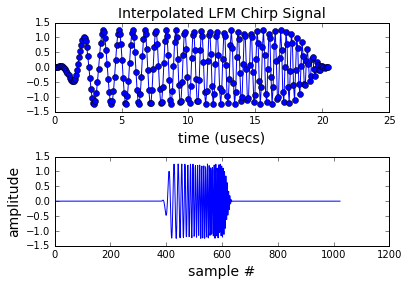

In [16]:
ax = plt.subplot(211)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)

## waveform constants
T = 20.48e-6         # chirp pulse width
BW = 2.5e6           # bandwidth of swept pulse
Fc = np.sqrt(BW*1e6) # chirp center frequency
Fs = 12.5e6          # sample rate in Hz
snr = 22
pathloss = 0    

f = Fc      # Hz, signal frequency (close to 2.5MHz)
N = 256      # number of samples in pulse (2^n) before zero padding
T = N/Fs    # pulse interval to give N samples
A = 1.25     # peak amplitude
t = np.arange(0,T,1/Fs) # pulse interval, symmetric for convenience later
#x = A*np.sin(2*np.pi*f*t)
win = 'tukey'
x = A*makeChirp(T, Fs, Fc, BW, win)
ax.plot(t,x,'o-')

# format xaxis tick labels as floats
locs,labels = plt.xticks()
plt.xticks(locs, map(lambda x: "%g" % x, 1e6*locs))

ax.set_title('Interpolated LFM Chirp Signal', fontsize=14)
# axis labels
ax.set_xlabel('time (usecs)',fontsize=14)

signal = np.zeros(1024)  # embed the pulse into a zero sequence at n/2
signal[511-N/2:511+N/2] = x
ax2 = plt.subplot(212)
ax2.plot(signal)

# axis labels
ax2.set_xlabel('sample #',fontsize=14)
ax2.set_ylabel('amplitude',fontsize=14)
plt.show()

## First Step: Compute the FFT

... and a matching vector of frequencies.  recall that FFT relates to frequency by multiplying each FFT bucket number (0, N-1) by $ F_s/N $ , where N = FFT length.  We'll us the pulse embedded in zeros for this since increasing the number of samples increases the resolution (and thus accuracy) of our FFT. For this example we'll use N=1024


 Frequencies (Hz): 
[' 0.00' '12207.03' '24414.06' ..., '-36621.09' '-24414.06' '-12207.03']




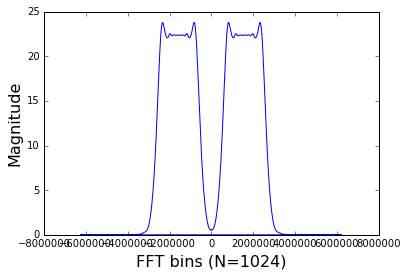

In [17]:
fft_x = np.fft.fft(signal)
n = len(fft_x)
freq = np.fft.fftfreq(n, 1/Fs)
plt.plot(freq, np.abs(fft_x))
print("\n Frequencies (Hz): ")
print(np.vectorize("%5.2f".__mod__)(freq))
print("\n")
plt.xlabel('FFT bins (N=1024)',fontsize=16)
plt.ylabel('Magnitude',fontsize=16)

## Swap Half Spaces

Note that frequencies in the FFT and freq vectors go from zero to some larger positive number then from a large negative number back toward zero. The fftshift() function right shifts the vectors so that the DC component is in the center of the vector with the positive values on the right.  The negative values are wrapped around to the left side of zero, maintaining a two-sided spectrum.

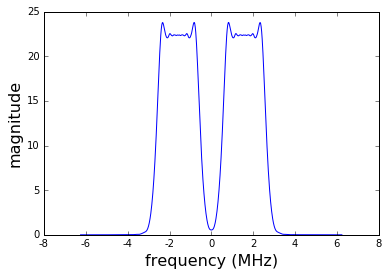

In [18]:
fft_x_shifted = np.fft.fftshift(fft_x)
freq_shifted = np.fft.fftshift(freq)
plt.plot(freq_shifted, np.abs(fft_x_shifted))

# format xaxis tick labels as floats
locs,labels = plt.xticks()
plt.xticks(locs, map(lambda x: "%g" % x, 1e-6*locs))

# axis labels, scaled from bins to Hz
plt.xlabel('frequency (MHz)',fontsize=16)
plt.ylabel('magnitude',fontsize=16)

## Fold Negative Frequencies and Scale

To get the time domain amplitude of the original waveform we begin by getting all the energy at a given frequency together in one bucket. FFTs take real signals and generate Hermitian (analytic) signals for each FFT bucket, meaning each output data point consists of a complex number in rectangular form. That explains why when we take the FFT of a sine wave we get two FFT peaks instead of one - the duplicate is the complex conjugate of the original complex frequency.  The signal here is a single frequency so we can discard the negative frequency buckets and simply adjust amplitudes later on. Next we scale by the length of the original FFT to adjust the amplitude.  As these are both linear operations, we can do them in any order we like, or in this case, at the same time. Note the factor of 2.0/N in the python code below which accomplishes both the folding and scaling. The factor N normalizes the result to the max value of a single bucket, while the 2x multiplier compensates for using just the positive frequencies in the calculation. 

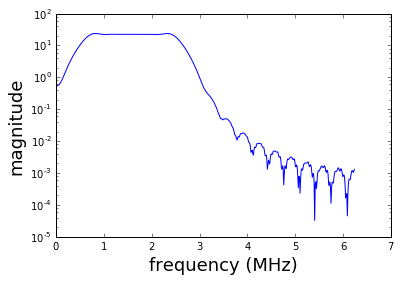

In [47]:
half_n = int(n/2.0)
fft_x_half = fft_x_shifted[half_n:]
freq_half = freq_shifted[half_n:]

plt.plot(freq_half, np.abs(fft_x_half))

# format xaxis tick labels as floats
locs,labels = plt.xticks()
plt.xticks(locs, map(lambda x: "%g" % x, 1e-6*locs))  # python-ese to make x-scale units correct
plt.yscale('log')
# axis labels
plt.xlabel('frequency (MHz)',fontsize=18)
plt.ylabel('magnitude',fontsize=18)

## PWM Chirp and its Spectrum

Generate the PWM signal from the chirp.  The original chirp created above doesn't work very well as the PWM input due to the coarseness of its sampling.   A 200MHz oversampled copy of the original chirp is created here to fix that problem.  The PWM carrier is a square wave of the same frequency as the chirp.  This produces a single pulse for each 1/2 cycle of the sinusoid.  The PWM type is 3-level.

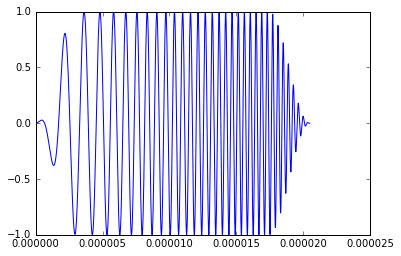

In [40]:
import scipy
import scipy.fftpack
from scipy import signal

Fs = 200.0e6
f = Fc      # Hz, signal frequency (close to 2.5MHz)
N = 4096         # number of samples in pulse (2^n) before zero padding
T = N/Fs         # pulse interval to give N samples
A = 1.0          # peak amplitude
t = np.arange(0,T,1/Fs) # pulse interval, symmetric for convenience later
win = 'tukey'
x = A*makeChirp(T, Fs, Fc, BW, win)
plt.plot(t,x)

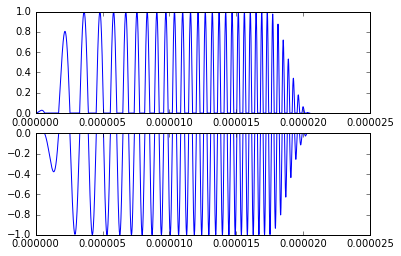

In [21]:
neg_x = np.array(x,copy=True)
pos_x = np.array(x, copy=True)
pos_x[pos_x<0] = 0
ax = plt.subplot(211)
ax.plot(t,pos_x)
ax2 = plt.subplot(212)
neg_x[neg_x>0] = 0
ax2.plot(t,neg_x)

The oversampled chirp has been split into the positive and negative waveforms shown above.  The final step is to quantize each into a 3 level output PCM wave [0:0.37, 0.37:0.707, 0.707:1.0] to end up with a 5 level PCM signal

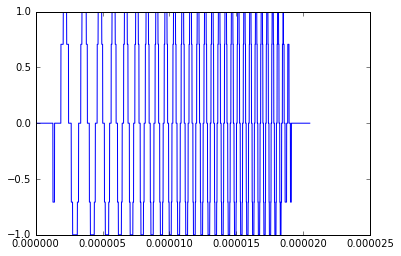

In [53]:
L1 = 0.37
L2 = 0.707
pcm = np.array(x, copy=True)
pcm[np.logical_and(pcm >= -L1, pcm < L1)] = 0
pcm[L2 <= pcm] = 1.0
pcm[-L2 >= pcm] = -1.0
pcm[np.logical_and(pcm >= L1, pcm < 1.0)] = L2
pcm[np.logical_and(pcm <= -L1, pcm > -1.0)] = -L2
plt.plot(t,pcm)


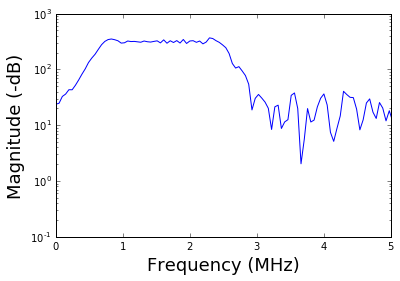

In [54]:
# sinusoid fft
fft_pcm = np.fft.fft(pcm)
pcm_len = len(fft_pcm)
freq_pcm = np.fft.fftfreq(pcm_len, 1/Fs)  # sample rate = 200MHz
fft_pcm_shifted = np.fft.fftshift(fft_pcm)
freq_pcm_shifted = np.fft.fftshift(freq_pcm)

plt.xlabel('Frequency',fontsize=14)
 
plt.plot(freq_pcm_shifted, np.abs(fft_pcm_shifted))

# format xaxis tick labels as floats
plt.xlim([0e6, 5e6])
locs,labels = plt.xticks()
plt.xticks(locs, map(lambda x: "%g" % x, 1e-6*locs))  # python-ese to make x-scale units correct
# axis labels
plt.xlabel('Frequency (MHz)',fontsize=18)
plt.ylabel('Magnitude (-dB)',fontsize=18)
plt.yscale('log')
plt.show()

## 2 Level PWM Chirp (for comparison)

Repeat the same thing we did last section, but use a 2 level (binary) encoding instead of the 5-level version.  

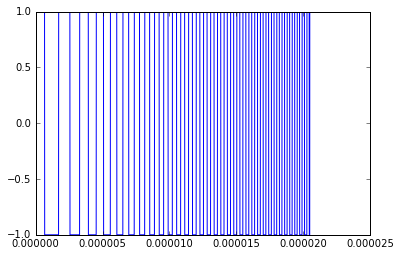

In [55]:
pcm = np.array(x, copy=True)
pcm[pcm <> 0] = np.sign(x)
plt.plot(t,pcm)


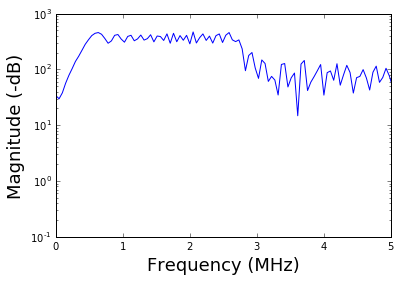

In [52]:
# sinusoid fft
fft_pcm = np.fft.fft(pcm)
pcm_len = len(fft_pcm)
freq_pcm = np.fft.fftfreq(pcm_len, 1/Fs)  # sample rate = 200MHz
fft_pcm_shifted = np.fft.fftshift(fft_pcm)
freq_pcm_shifted = np.fft.fftshift(freq_pcm)

plt.xlabel('Frequency',fontsize=14)
 
plt.plot(freq_pcm_shifted, np.abs(fft_pcm_shifted))

# format xaxis tick labels as floats
plt.xlim([0e6, 5e6])
locs,labels = plt.xticks()
plt.xticks(locs, map(lambda x: "%g" % x, 1e-6*locs))  # python-ese to make x-scale units correct
plt.yscale('log')
# axis labels
plt.xlabel('Frequency (MHz)',fontsize=18)
plt.ylabel('Magnitude (-dB)',fontsize=18)
plt.show()

## Conclusion/Summary

**References**  

[1] F. Harris, "On the use of windows for harmonic analysis with the discrete Fourier transform," Proceedings of the IEEE, Vol. 66, No. 1, pp. 51-83, January 1978.

[2] E. Jacobsen, and R. Lyons, "The Sliding DFT", IEEE Signal Processing Magazine, DSP Tips & Tricks column, March, 2003.